In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import sys
import gzip
from scipy import stats
import scipy as sp
import community

from network_ei import *
from get_motifs import *
from causal_emergence import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

# Causal Structure as a Network: Quantifying Certainty in Complex Systems

# Chapter 04: Causal Emergence in Networks

## Effective Information at the Macro Scale
This new global network measure, $EI$, offers a principled way to ask important questions for studying systems in general: what is the most suitable model that accurately captures the information about causation in a system? What representation will minimize the noise present in a network?

Science analyzes the causal structure of different systems at different spatiotemporal scales, often preferring to intervene and observe certain systems at levels far above that of the microscale (Hoel, 2018). This presents a problem  or paradox, a fact long highlighted in analytic philosophy (Fodor, 1974; Kim, 2000). To state the issue mathematically: it seems impossible to gain information by reducing the dimensionality of a system (via a macro-scale like a coarse-grain). Such macro-scales seem to be definitionally throwing information away. While there have been many attempts to circumnavigate this issue in a scientific manner (Anderson, 1972; Campbell, 1974; Bunge, 1963; Sperry, 1969), the more qualitative approaches have implicitly concluded that at best a macro-scale can be lossless and preserve micro-scale dynamics successfully (Crutchfield, 1994; Wolpert, Grochow, Libby, & DeDeo, 2014).

What has been often overlooked is the role of noise in causal relationships. Causal relationships at the micro-scale can be extremely noisy and therefore uninformative, and coarse-graining can minimize thisn oise (Hoel et al., 2013).  Indeed, this causal emergence is actually grounded in Claude Shannon’s noisy-channel coding theorem (Hoel, 2017; Shannon, 1948), and dimensional reductions operate like codes that usemore of a channel’s capacity. Ultimately it reveals that sometimes higher-level causal relationships performerror correction on the lower-level relationships, thus generating extra information at those higher scales by combating noise. Measuring this difference provides a principled means of deciding when higher-scales aremore informative (emergence) vs when higher scales are extraneous, epiphenomenal, or lossy (reduction).

In a network approach to causal structure, causal emergence is when a dimensionally-reduced network is actually more informative. That is, it is possible to recast a network, $G_0$, into a new, coarse-grained network, $G_m$, consisting of *micro-nodes*, *macro-nodes*, and the edges between them. In $G_m$, a micro-node is a node that was present in the original $G_0$, and a macro-node is defined as a $\text{node}_i$ that represents a subgraph, $S_i$, in the original $G_0$ such that $N_{G_0} > N_{G_m}$. Causal emergence occurs if such a recast network, $G_m$, has more $EI$ than the original network, $G_0$, with all of its nodes and edges. 

Figure 5 below shows a trivial example of both emergence and reduction in two simple systems. The first (top row) is composed of binary *copy*-gates (the state of one node is copied by the other node), while the second is composed of *and*-gates (the states of both nodes determine the subsequent state of one node). In the final column of Figure 5, the first system is shown to be an example of causal reduction is shown (top row) while the second is an example of causal emergence (bottom row). All possible coarse-grained networks were searched to find the network with maximal $EI$ in each system.

_____________________________________________

## Causal Communities
Applying such an analysis to complex networks would be useful in improving scientific experimental design, the compression and search of big data, model choice, and even machine learning. However, one issue is the combinatorially vast space of possible coarse-grained networks, especially in large networks, as real network datasets often are. While only a small fraction of coarse-grained networks contain more $EI$ than the original network, finding a maximum is been a computational bottleneck for all but the smallest networks. However, there are useful heuristics for implementing this coarse-graining process. In this notebook, we show several example methods for coarse-graining a given network (in this case, a Barabási-Albert Network where $N=200$, $m=2$). In both cases, we create macro-nodes by pairing two nodes in the network together, grouping them into a single node. If this operation increases the $EI$ in the network, then causal emergence is the amount of $EI$ gained through that coarse-graining. Grouping pairs of nodes in a network is relatively cheap computationally, but grouping three nodes into a macro-node increases the search space enormously (as does four-node groupings, etc.). In further research, we intend to develop efficient ways to group more than two nodes at a time.

Fundamentally, this process of iteratively creating macro-nodes can be interpreted as discovering \textit{causal communities} in a given network. Indeed, we define a causal community as any set of nodes that shares overlap in their inputs and outputs such that when grouped into a macro-node, the resulting network $G_m$ has a higher $EI$ than the original network, $G_0$. It follows that only groupings that reduce the entropy of $W_{i}^{out}$ or increase the entropy of $W_{in}$ will be causal communities. Similarly if you group over anything that is *not* a causal community, you will either increase your degeneracy or decrease you determinism, thus decreasing the $EI$. 

Finally, by defining a causal community in a network, we are able to make an observation about the (micro-) nodes that constitute the causal community: namely, all causal communities represent noise at the micro-level, and we can minimize the noise in a given network by creating macro-nodes, thereby defining a more optimal scale to represent using a given network.
_____________________________________________

<img src="figs/pngs/CausalModel_to_NetworkCausalEmergence.png">

Figure 5: **The presence and absence of higher-scale causation in two simple causal structures.** Two systems, a *copy*-gate (top row) and an *and*-gate (bottom row), their associated transition probability matrices, the network formed if the transition probability matrix were an adjacency matrix, and the same higher scale representation of each network. Representing the *copy* system with a macro-node loses 1 bit of $EI$, while representing the *and* system in the same way leads to an increase of 0.17 bits.

In [2]:
def get_nodebunch_rw(G, nodebunch_size=4, node_i=[], random_grouping=True):
    """
    Given a graph, this function picks a node and
    returns the tuple of the most overlapping neighbor.
    """
    if random_grouping:
        if node_i==[]:
            node_i = np.random.choice(list(G.nodes()))
    else: 
        deg = np.array(list(dict(G.degree()).values()))
        ps = deg/sum(deg)
        choice = np.random.multinomial(1, ps)
        node_i = np.nonzero(choice)[0][0]
        
    random_walks = [node_i]
    neih_i = list(G.neighbors(node_i))
    nodebunch_size = nodebunch_size-1
    
    while nodebunch_size > 0:
        node_j = np.random.choice(neih_i)
        random_walks.append(node_j)
        nodebunch_size = nodebunch_size-1
        node_i = node_j
        neih_i = list(G.neighbors(node_i))
    
    return list(set(random_walks))

def get_nodebunch_induced(G, nodebunch_size=4, node_i=[], random_grouping=True):
    """
    Given a graph, this function picks a node and returns
    the tuple of the most overlapping neighbor.
    """
    if random_grouping:
        if node_i==[]:
            node_i = np.random.choice(list(G.nodes()))
            
    else: 
        deg = np.array(list(dict(G.degree()).values()))
        ps = deg/sum(deg)
        choice = np.random.multinomial(1, ps)
        node_i = np.nonzero(choice)[0][0]
        
    random_walks = [node_i]
    neih_i = list(G.neighbors(node_i))
    nodebunch_size = nodebunch_size-1
    
    while nodebunch_size > 0:
        node_j = np.random.choice(neih_i)
        random_walks.append(node_j)
        nodebunch_size = nodebunch_size-1
        node_i = node_j
        neih_i = list(G.neighbors(node_i))
    
    return list(set(random_walks))

def get_nodebunch_random(G, nodebunch_size):
    """
    Returns a randomly-selected nodebunch of size nodebunch_size.
    """
    if nodebunch_size < 2: nodebunch_size = 2
    nodebunch = []
    
    for node in range(nodebunch_size):
        nodebunch.append(np.random.choice(list(set(G.nodes())-set(nodebunch))))
    
    return nodebunch

def macronode(G, nodebunch_size=2, p0=np.exp(-30), nodebunch=[], printt=False):
    """
    Takes a group of m nodes and turns them into a
    macronode, preserving edge weights.
    """
    G = check_network(G)

    W_out0 = get_Wout_full(G, p0)
    W_in_0 = get_Win(G, p0)

    temp = np.vstack((W_out0.T,np.zeros(W_out0.shape[0])))
    W_out_m = np.vstack((temp.T,np.zeros(temp.shape[0])))
    W_in_m = np.append(W_in_0, np.zeros(1))
    
    if nodebunch == []: 
        nodebunch=get_nodebunch_random(G, nodebunch_size)
    
    nodebunch = [int(i) for i in nodebunch]
    W_out_macro_sum = sum([W_out0[i] for i in nodebunch])
    
    if sum(W_out_macro_sum) > 0:
        W_out_macro = W_out_macro_sum/sum(W_out_macro_sum)
    else:
        W_out_macro = np.zeros(len(W_out_macro_sum))
        
    W_out_macro = np.append(W_out_macro, np.zeros(1))
    W_out_m[(W_out_m.shape[0] - 1)] = W_out_macro
    
    W_in_macro = []
    
    for j in range(W_out0.shape[0]):
        W_in_macro.append(sum(W_out0[j][nodebunch]))
        W_out0[j][nodebunch] = np.zeros(len(nodebunch))
    
    W_in_macro = np.append(np.array(W_in_macro), np.zeros(1))
    W_out_m.T[(W_out_m.shape[0]-1)] = W_in_macro
    
    W_out_m[-1][-1] = sum(W_out_m[-1][nodebunch])
    W_m = np.delete(W_out_m, nodebunch, 0)
    W_out = np.delete(W_m.T, nodebunch, 0).T
    
    W = np.zeros(W_out.shape)
    thresh = 1/(W.shape[0]+1)
    for i in range(W.shape[0]):
        if len(W_out[i][np.where(W_out[i] > thresh)]) > 0:
            W[i][np.where(W_out[i]>thresh)[0]] = W_out[i][np.where(W_out[i]>thresh)[0]]

    Gm = nx.from_numpy_array(W, create_using=nx.DiGraph())
    
    if printt:
        Gprint = np.array(np.round(get_Wout_full(G, p0),2), dtype=str)
        for i in nodebunch:
            strs = np.array(["XXX" if x=="0.0" else str(x) for x in Gprint[i]])
            Gprint[i] = strs
        print("Original network with size =",G0.number_of_nodes(),"\n",Gprint)
        print()
        print("Turns into a coarse-grained network after macronoding over nodes:",nodebunch)
        print()
        print("Macronoded network with size =",Gm.number_of_nodes(),"\n", 
              np.array(np.round(nx.to_numpy_array(Gm), 2), dtype=str))

    return Gm

def get_paths_i(G, node_i, d=2):
    """
    Gets an edgelist of all edges [node_i, node_k] made
    from paths of length d from node_i.
    """
    node_i = type(list(G.nodes())[0])(node_i)    
    nodes_j0 = list(G.neighbors(node_i))

    if d==1:
        out = list(zip([node_i]*len(nodes_j0), nodes_j0))

    elif d==2:
        nodes_k = []
        for node_j1 in nodes_j0:
            for node_k in list(G.neighbors(node_j1)):
                if node_k != node_i:
                    nodes_k.append(node_k)
        nodes_k = set(nodes_k)        
        out = list(zip([node_i]*len(nodes_k), nodes_k))

    elif d==3:
        nodes_k = []
        for node_j1 in nodes_j0:
            for node_j2 in list(G.neighbors(node_j1)):
                for node_k in list(G.neighbors(node_j2)):
                    if node_k != node_i:
                        nodes_k.append(node_k)
        nodes_k = set(nodes_k)
        out = list(zip([node_i]*len(nodes_k), nodes_k))

    elif d==4:
        nodes_k = []
        for node_j1 in nodes_j0:
            for node_j2 in list(G.neighbors(node_j1)):
                for node_j3 in list(G.neighbors(node_j2)):
                    for node_k in list(G.neighbors(node_j3)):
                        if node_k != node_i:
                            nodes_k.append(node_k)
        nodes_k = set(nodes_k)
        out = list(zip([node_i]*len(nodes_k), nodes_k))
    
    return out
        
def get_paths(G, d=2):
    """
    Gets all edges [node_i, node_k] made from paths of length d in the network.
    """
    all_length2_paths = []
    for node_i in G.nodes():
        paths_i = get_paths_i(G, node_i, d)
        for node_k in paths_i:
            if node_k != node_i:
                all_length2_paths.append(node_k)
        
        all_length2_paths = list(set(all_length2_paths))
            
    return list(set(all_length2_paths))

def get_communities(graph):
    """
    Wrapper for community detection algorithms.
    """
    return community.best_partition(graph)

def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    A = A/np.sum(A)
    return A

def normalized(A):
    """
    Normalizing a vector.
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    return [float(i)/sum(A) for i in A]

## 4.0.1 Grouping Nodes, then Compairing $EI$
_________________________

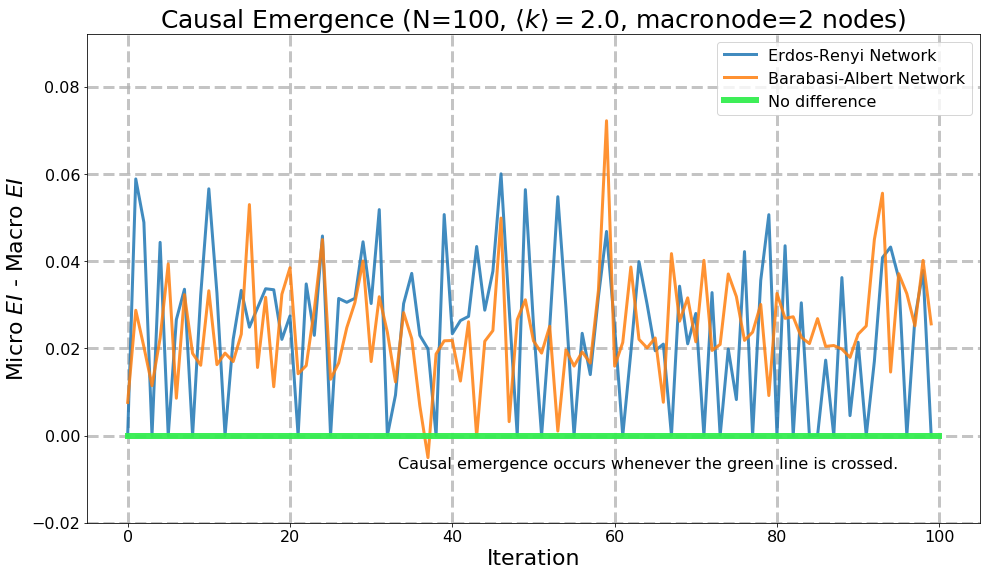

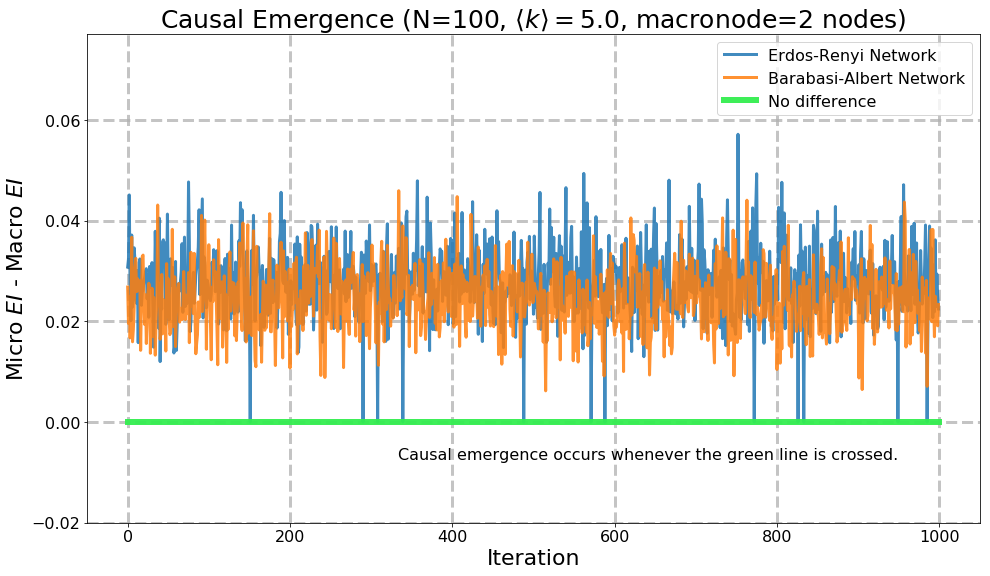

In [3]:
nodebunch_size = 2 # pairing two random nodes
N = 100
K_avg = 2 # sparse network
n_sim = 100

diff_er = []
diff_ba = []
for i in range(n_sim):
    Ger = nx.erdos_renyi_graph(N,K_avg/N)
    Gmer = macronode(Ger, nodebunch_size=nodebunch_size)
    diff_er.append(get_ei(Ger)-get_ei(Gmer))

    Gba = nx.barabasi_albert_graph(N,K_avg)
    Gmba = macronode(Gba, nodebunch_size=nodebunch_size)
    diff_ba.append(get_ei(Gba)-get_ei(Gmba))       
    
plt.figure(figsize=(16,9))
plt.plot(diff_er, label="Erdos-Renyi Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot(diff_ba, label="Barabasi-Albert Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot([0, len(diff_er)],[0,0], label="No difference", 
         color="#33ee4f", alpha=0.95, markeredgewidth=4, linewidth=6.0)
plt.text(n_sim/3, -0.0075, 
         "Causal emergence occurs whenever the green line is crossed.", 
         ha='left', rotation=0, wrap=True, size=16)

plt.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
plt.title(r"Causal Emergence (N=100, $\langle k \rangle = 2.0$, macronode=2 nodes)", size=25)
plt.xlabel("Iteration", size=22)
plt.ylabel("Micro $EI$ - Macro $EI$", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(-0.02, max([max(diff_er), max(diff_ba)])+0.02)
plt.legend(fontsize=16)
# plt.savefig("figs/CaussalEmergence_100N_2k_2n_ERBA.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CaussalEmergence_100N_2k_2n_ERBA.png", dpi=425, bbox_inches='tight')
plt.show()

######################################################################################

nodebunch_size = 2 # pairing two random nodes
N = 100
K_avg = 5 # denser network
n_sim = 1000

diff_er = []
diff_ba = []
for i in range(n_sim):
    Ger = nx.erdos_renyi_graph(N,K_avg/N)
    Gmer = macronode(Ger, nodebunch_size=nodebunch_size)
    diff_er.append(get_ei(Ger)-get_ei(Gmer))

    Gba = nx.barabasi_albert_graph(N,K_avg)
    Gmba = macronode(Gba, nodebunch_size=nodebunch_size)
    diff_ba.append(get_ei(Gba)-get_ei(Gmba))       
    
plt.figure(figsize=(16,9))
plt.plot(diff_er, label="Erdos-Renyi Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot(diff_ba, label="Barabasi-Albert Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot([0, len(diff_er)],[0,0], label="No difference", 
         color="#33ee4f", alpha=0.95, markeredgewidth=4, linewidth=6.0)
plt.text(n_sim/3, -0.0075, 
         "Causal emergence occurs whenever the green line is crossed.", 
         ha='left', rotation=0, wrap=True, size=16)

plt.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
plt.title(r"Causal Emergence (N=100, $\langle k \rangle = 5.0$, macronode=2 nodes)", size=25)
plt.xlabel("Iteration", size=22)
plt.ylabel("Micro $EI$ - Macro $EI$", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(-0.02, max([max(diff_er), max(diff_ba)])+0.02)
plt.legend(fontsize=16)
# plt.savefig("figs/CaussalEmergence_100N_5k_2n_ERBA.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CaussalEmergence_100N_5k_2n_ERBA.png", dpi=425, bbox_inches='tight')
plt.show()

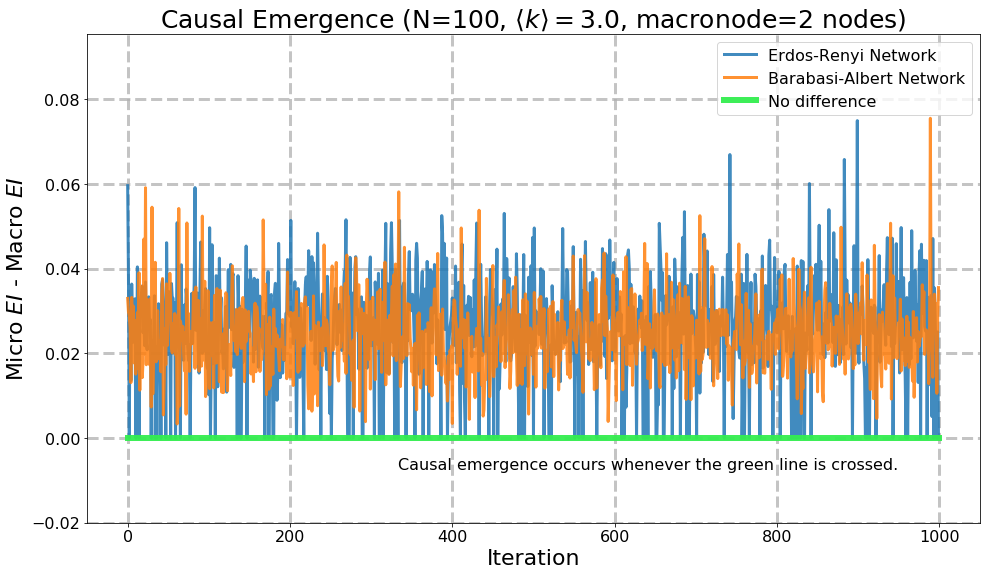

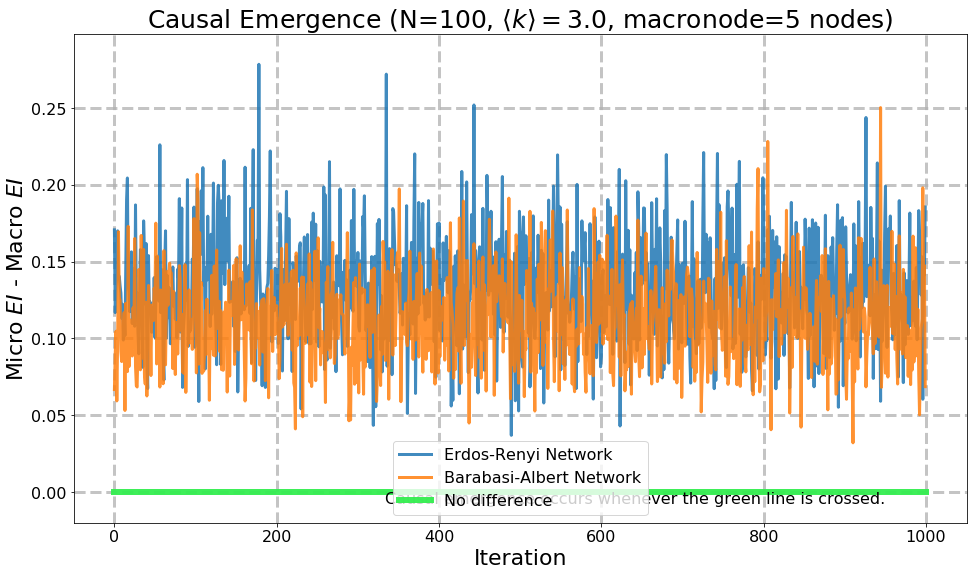

In [39]:
nodebunch_size = 2 # pairing two random nodes
N = 100
K_avg = 3 # sparse network
n_sim = 1000

diff_er = []
diff_ba = []
for i in range(n_sim):
    Ger = nx.erdos_renyi_graph(N,K_avg/N)
    Gmer = macronode(Ger, nodebunch_size=nodebunch_size)
    diff_er.append(get_ei(Ger)-get_ei(Gmer))

    Gba = nx.barabasi_albert_graph(N,K_avg)
    Gmba = macronode(Gba, nodebunch_size=nodebunch_size)
    diff_ba.append(get_ei(Gba)-get_ei(Gmba))       
    
plt.figure(figsize=(16,9))
plt.plot(diff_er, label="Erdos-Renyi Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot(diff_ba, label="Barabasi-Albert Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot([0, len(diff_er)],[0,0], label="No difference", 
         color="#33ee4f", alpha=0.95, markeredgewidth=4, linewidth=6.0)
plt.text(n_sim/3, -0.0075, 
         "Causal emergence occurs whenever the green line is crossed.", 
         ha='left', rotation=0, wrap=True, size=16)

plt.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
plt.title(r"Causal Emergence (N=100, $\langle k \rangle = 3.0$, macronode=2 nodes)", size=25)
plt.xlabel("Iteration", size=22)
plt.ylabel("Micro $EI$ - Macro $EI$", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(-0.02, max([max(diff_er), max(diff_ba)])+0.02)
plt.legend(fontsize=16)
# plt.savefig("figs/CaussalEmergence_100N_3k_2n_ERBA.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CaussalEmergence_100N_3k_2n_ERBA.png", dpi=425, bbox_inches='tight')
plt.show()

######################################################################################

nodebunch_size = 5 # pairing five random nodes
N = 100
K_avg = 3 # denser network
n_sim = 1000

diff_er = []
diff_ba = []
for i in range(n_sim):
    Ger = nx.erdos_renyi_graph(N,K_avg/N)
    Gmer = macronode(Ger, nodebunch_size=nodebunch_size)
    diff_er.append(get_ei(Ger)-get_ei(Gmer))

    Gba = nx.barabasi_albert_graph(N,K_avg)
    Gmba = macronode(Gba, nodebunch_size=nodebunch_size)
    diff_ba.append(get_ei(Gba)-get_ei(Gmba))       
    
plt.figure(figsize=(16,9))
plt.plot(diff_er, label="Erdos-Renyi Network", alpha=0.85,
         markeredgewidth=4, linewidth=3.0)
plt.plot(diff_ba, label="Barabasi-Albert Network", alpha=0.85, 
         markeredgewidth=4, linewidth=3.0)
plt.plot([0, len(diff_er)],[0,0], label="No difference", 
         color="#33ee4f", alpha=0.95, markeredgewidth=4, linewidth=6.0)
plt.text(n_sim/3, -0.0075, 
         "Causal emergence occurs whenever the green line is crossed.", 
         ha='left', rotation=0, wrap=True, size=16)

plt.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
plt.title(r"Causal Emergence (N=100, $\langle k \rangle = 3.0$, macronode=5 nodes)", size=25)
plt.xlabel("Iteration", size=22)
plt.ylabel("Micro $EI$ - Macro $EI$", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylim(-0.02, max([max(diff_er), max(diff_ba)])+0.02)
plt.legend(fontsize=16)
# plt.savefig("figs/CaussalEmergence_100N_3k_5n_ERBA.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CaussalEmergence_100N_3k_5n_ERBA.png", dpi=425, bbox_inches='tight')
plt.show()

## 4.0.2 Visualizing Causal Emergence
_________________________

5.112081756595911


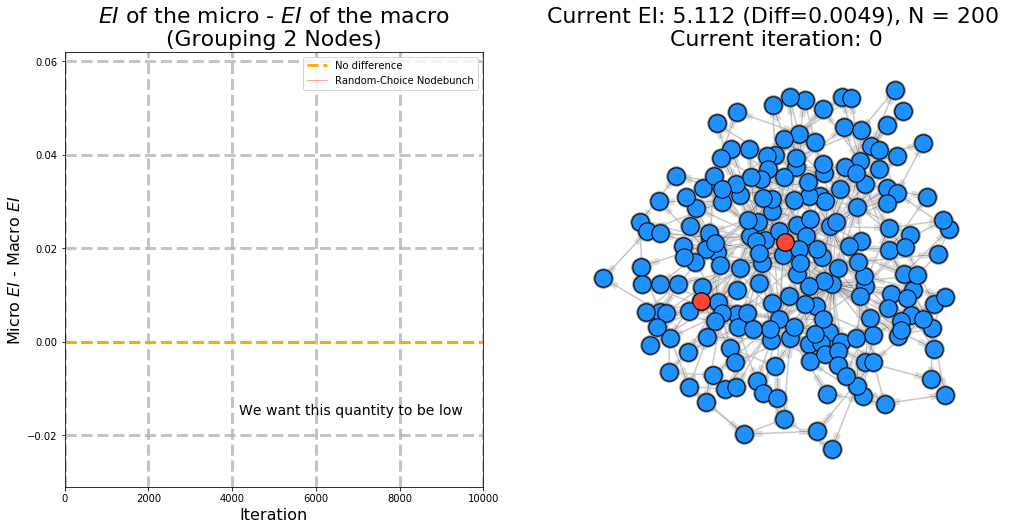

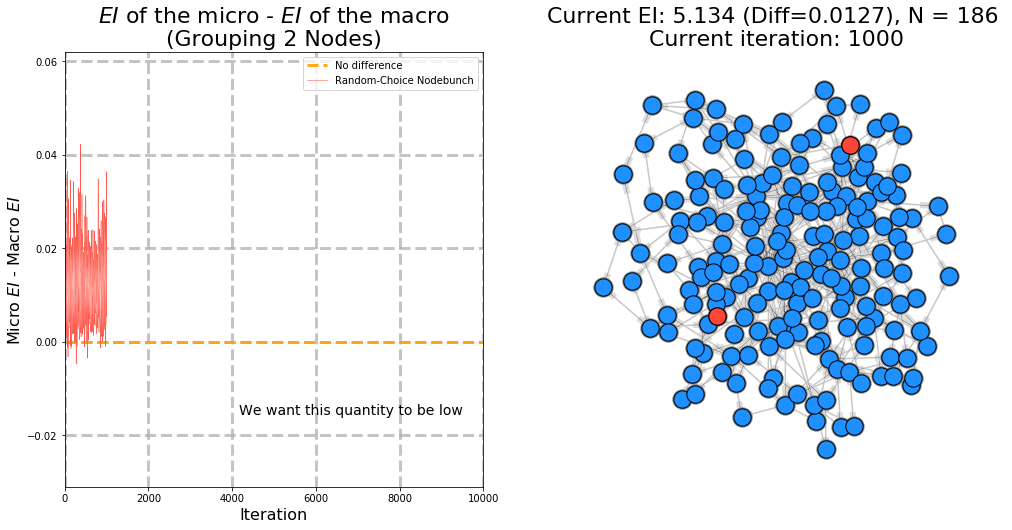

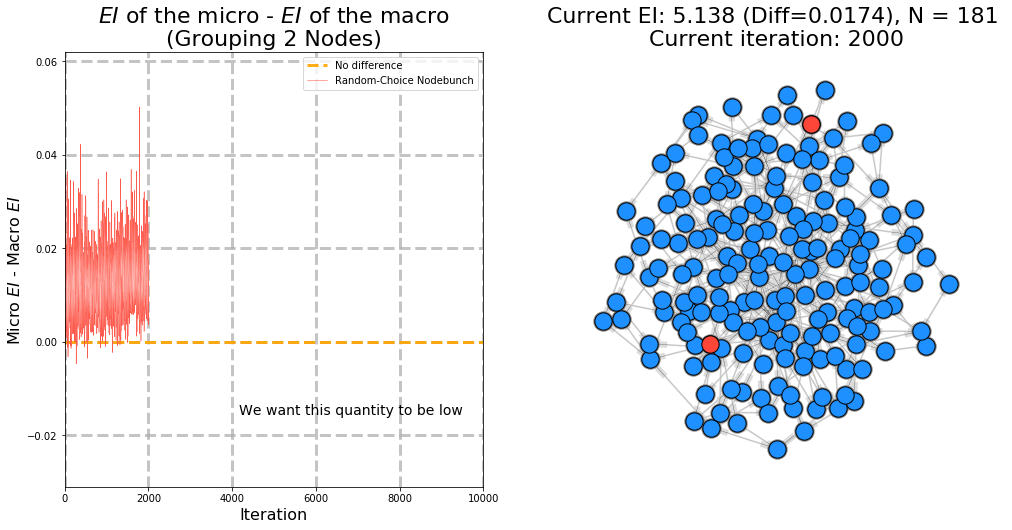

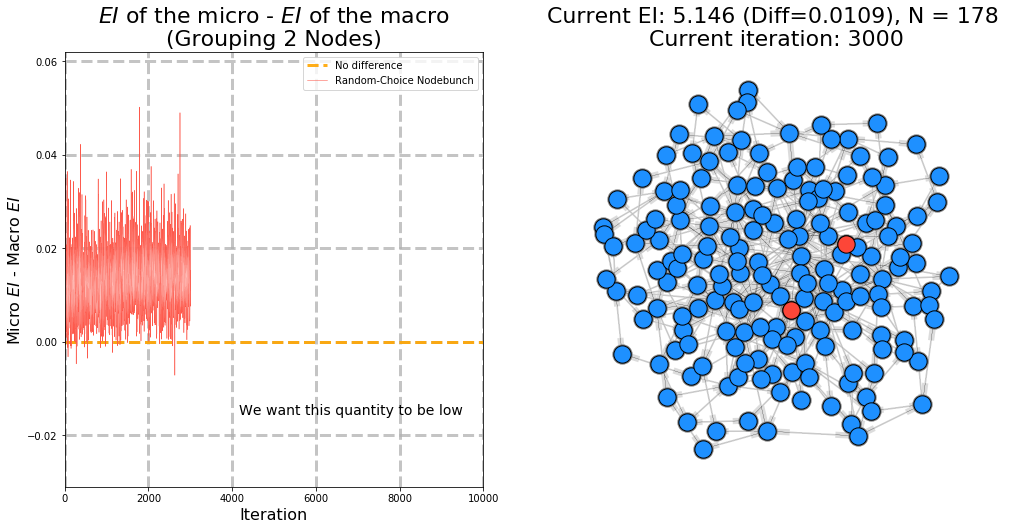

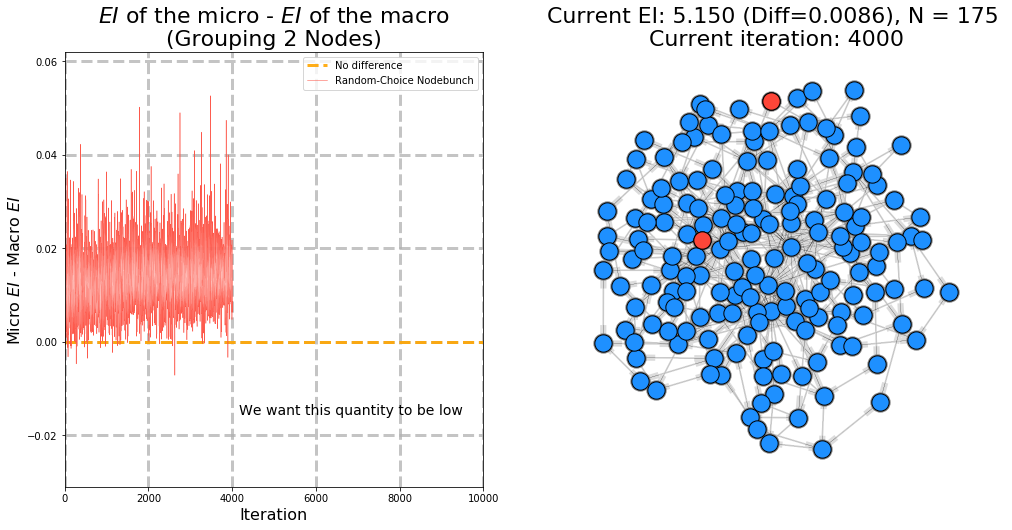

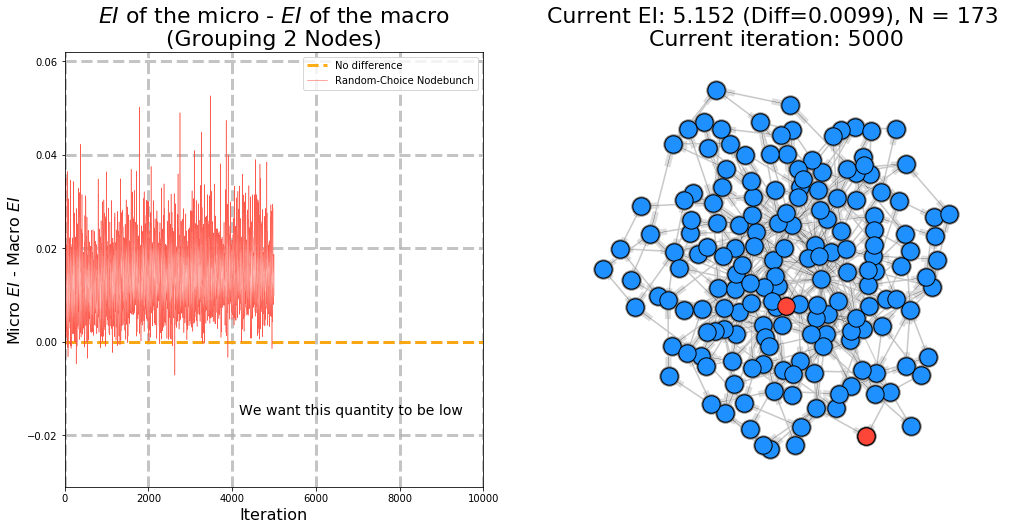

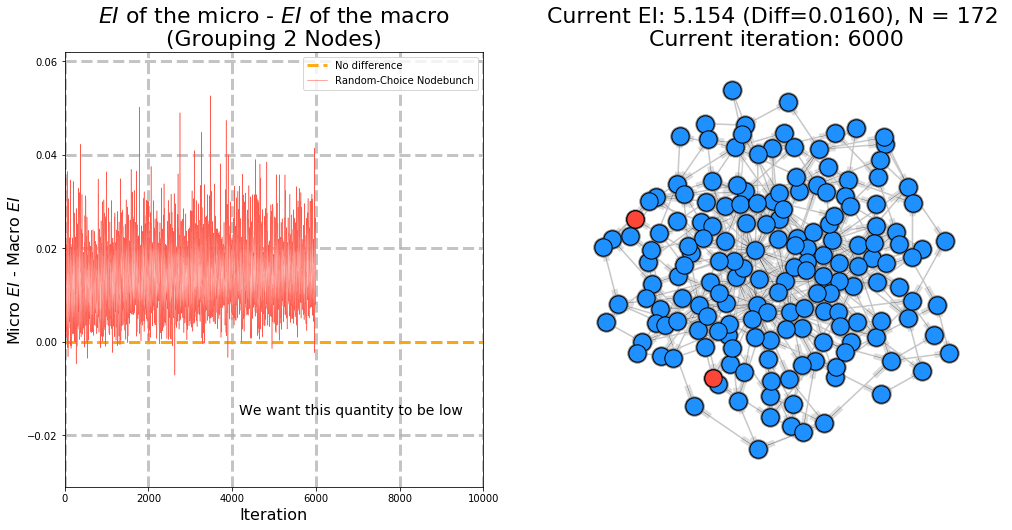

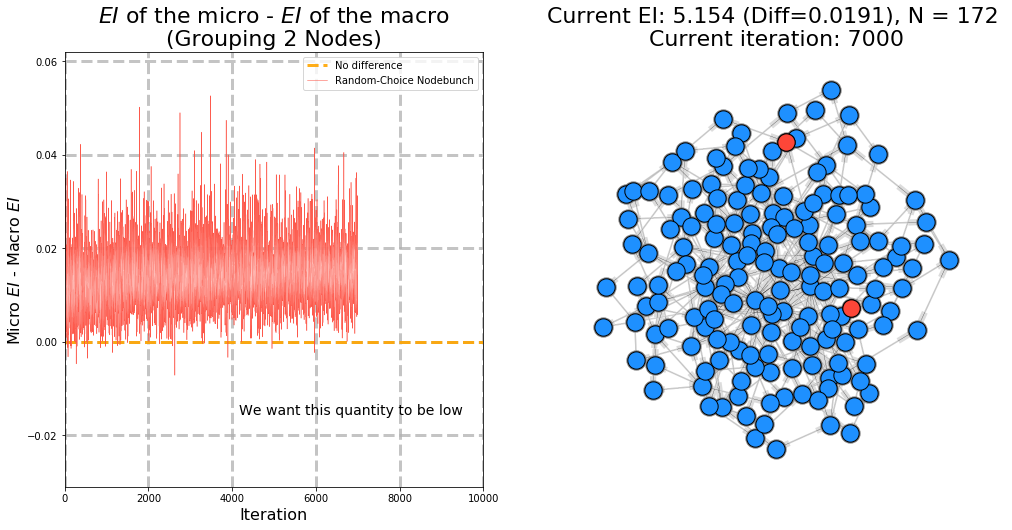

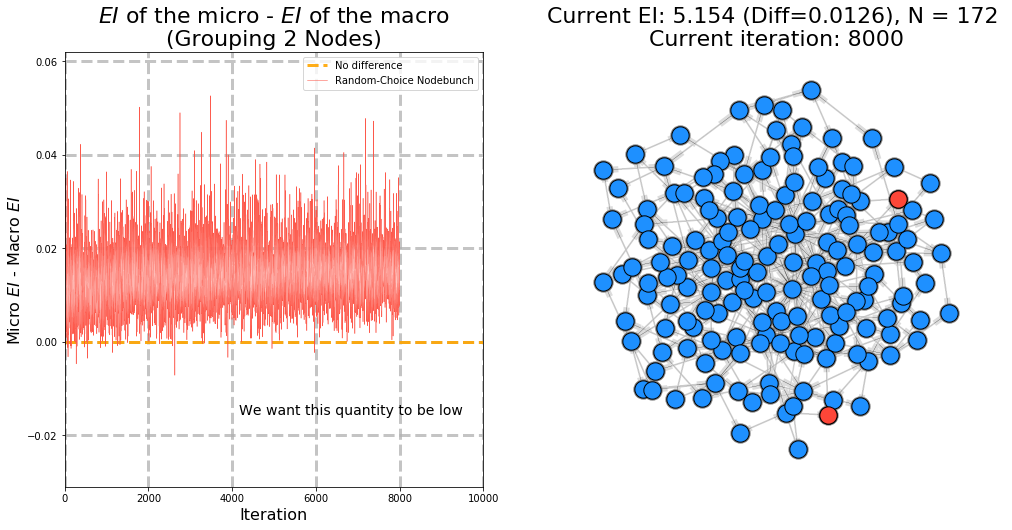

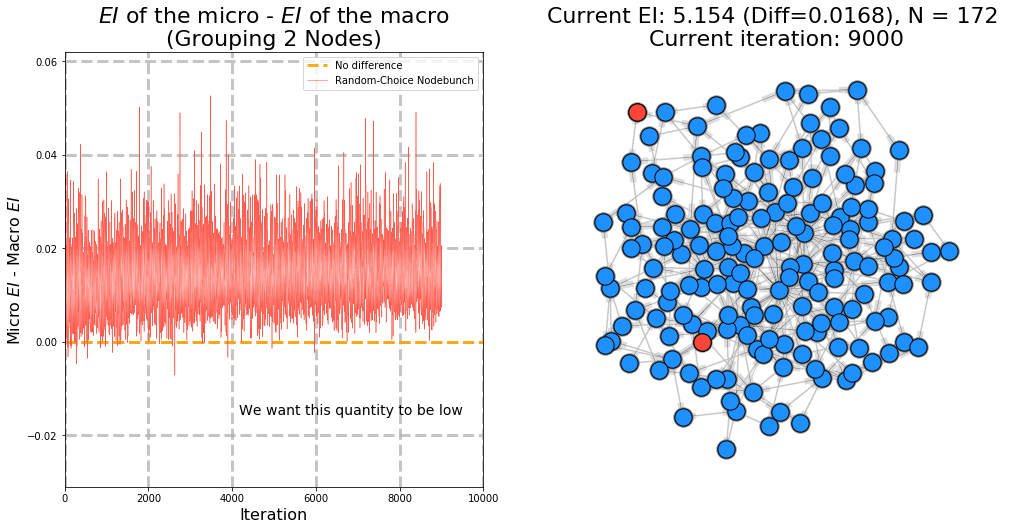

In [109]:
N = 200
K_avg = 2

Ger0 = nx.barabasi_albert_graph(N,K_avg)
# Ger0 = nx.erdos_renyi_graph(N,K_avg/N)
# while nx.number_connected_components(Ger0) > 1:
#     Ger0 = nx.erdos_renyi_graph(N,K_avg/N)

Ger0 = nx.to_directed(Ger0)
ei_Ger0 = get_ei(Ger0)
ei_er_macro = [ei_Ger0]
y_min = 0.031
ei_diff0 = [y_min*K_avg]
ei_er0 = []
nodebunch_size_min = 2; nodebunch_size_max = int(K_avg+1)
nodebunch_size_range = range(nodebunch_size_min, nodebunch_size_max)
size_dict = dict(zip(nodebunch_size_range, [0]*len(nodebunch_size_range)))
n_sim = 10000
macros0 = []
print(ei_Ger0)
pos = nx.kamada_kawai_layout(Ger0)

for i in range(n_sim):
    nodebunch_size = np.random.choice(nodebunch_size_range)
    nodebunch0 = get_nodebunch_random(Ger0, nodebunch_size)
    Gmer0 = macronode(Ger0, nodebunch=nodebunch0)
    ei_diff0.append(get_ei(Ger0)-get_ei(Gmer0))
    if get_ei(Gmer0) > get_ei(Ger0):
        Ger0 = Gmer0.copy()
        macros0.append(Gmer0)
        size_dict[nodebunch_size] += 1
        ei_Ger0 = get_ei(Ger0)
        pos = nx.kamada_kawai_layout(Gmer0)

    ei_er0.append(ei_Ger0)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16.5,8))
    ax0.plot([0, n_sim],[0,0], label="No difference", color='orange',
             alpha=0.9, linestyle='--',linewidth=3.0)
    
    if ei_diff0[i] < 0:
        ax0.plot(ei_diff0, color='magenta', alpha=0.85, linewidth=5.0)
    ax0.plot(ei_diff0, label="Random-Choice Nodebunch", color='#fd4638',
             alpha=0.95, linewidth=0.5)
    ax0.plot(ei_diff0, color='white', alpha=0.95, linewidth=0.05)

    ax0.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
    ax0.set_title("$EI$ of the micro - $EI$ of the macro\n(Grouping %i Nodes)" % (nodebunch_size), size=22)
    ax0.set_xlabel("Iteration", size=16)
    ax0.set_ylabel("Micro $EI$ - Macro $EI$", size=16)
    ax0.text(n_sim/2.4, -y_min/2, "We want this quantity to be low", ha='left', rotation=0, wrap=True, size=14)
    ax0.set_xlim(-1,n_sim)
    ax0.set_ylim(-y_min, max(ei_diff0))
    ax0.legend(fontsize=10)

    pos = nx.spring_layout(Ger0, pos=pos)
    nx.draw_networkx_nodes(Ger0, pos, node_color='dodgerblue', 
                           linewidths=3, alpha=0.95, ax=ax1).set_edgecolor('grey')
    nx.draw_networkx_nodes(Ger0, pos, node_color='dodgerblue', 
                           linewidths=1, ax=ax1).set_edgecolor('k')
    if Gmer0.number_of_nodes() < Ger0.number_of_nodes():
        nx.draw_networkx_nodes(Ger0, pos, nodelist=nodebunch0, node_color='#fd4638', 
                               linewidths=1, ax=ax1).set_edgecolor('k')
    else:
        nx.draw_networkx_nodes(Ger0, pos, nodelist=[list(Ger0.nodes())[-1]], 
                               node_color='lime', node_size=2500,
                               linewidths=1, ax=ax1, alpha=0.87).set_edgecolor('white')
        
    nx.draw_networkx_edges(Ger0, pos, edge_color="gainsboro", width=1.55, alpha=0.98, ax=ax1)
    nx.draw_networkx_edges(Ger0, pos, edge_color="black", width=0.05, alpha=0.8, ax=ax1)
    title = "Current EI: %.3f (Diff=%.4f), N = %i \n Current iteration: %i " % \
        (get_ei(Ger0), ei_diff0[-1], Ger0.number_of_nodes(), i)
    ax1.set_title(title, size=22)
    plt.axis('off')
    if i % int(n_sim/10)==0:
        plt.show()
    else: 
        plt.close()

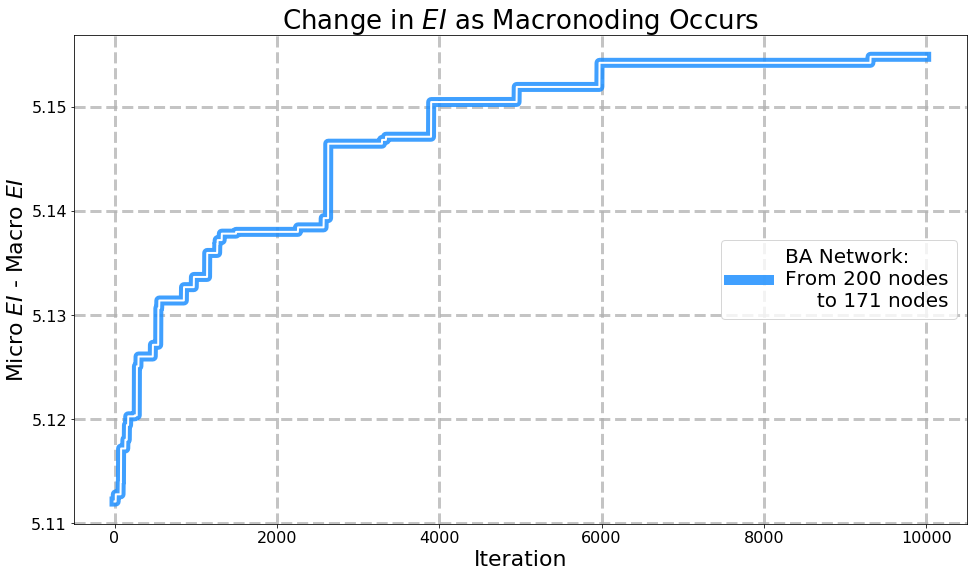

In [129]:
for i in range(len(ei_diff0)):
    if ei_er_macro[i] > ei_er_macro[i]-ei_diff0[i]:
        ei_er_macro.append(ei_er_macro[i])
    else:
        ei_er_macro.append(ei_er_macro[i]-ei_diff0[i])

plt.figure(figsize=(16,9))
plt.plot(ei_er_macro[:n_sim], label="BA Network:\nFrom %i nodes\n     to %i nodes"%(N, Ger0.number_of_nodes()), 
         color="dodgerblue", alpha=0.85, linewidth=10.0)
plt.plot(ei_er_macro[:n_sim], linewidth=2.0, color='w')

plt.grid(True, linestyle='--', linewidth=3.0, alpha=0.75)
plt.title("Change in $EI$ as Macronoding Occurs", size=26)
plt.xlabel("Iteration", size=22)
plt.ylabel("Micro $EI$ - Macro $EI$", size=22)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=20, loc=5)#, bbox_to_anchor=[0.195, 0.43])
# plt.savefig("figs/CausalEmergence_CumulativeEI.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CausalEmergence_CumulativeEI.png", dpi=425, bbox_inches='tight')
plt.show()

## 4.1.0 Searching *Edges*: Which Nodes Make the Best Macronodes?
_________________________

In [ ]:
N = 200
K_avg = [1,2,3]

G1 = nx.barabasi_albert_graph(N, K_avg[0])
G2 = nx.barabasi_albert_graph(N, K_avg[1])
G3 = nx.barabasi_albert_graph(N, K_avg[2])
ei_G1 = get_ei(G1)
ei_G2 = get_ei(G2)
ei_G3 = get_ei(G3)
ei_diff_edges1 = []
ei_diff_edges2 = []
ei_diff_edges3 = []
success_edges1 = []
success_edges2 = []
success_edges3 = []
edges1 = list(G1.edges())
edges2 = list(G2.edges())
edges3 = list(G3.edges())

for eij in edges1:
    Gij = macronode(G1, nodebunch=list(eij))
    ei_diff_edges1.append(get_ei(G1) - get_ei(Gij))
print("For BA Network with",N,"nodes and k_avg of",K_avg[0]*2)
print("Edge ID \t (k_i, k_j) \t (EI_i, EI_j) \t\t EI_diff")
for i in range(len(ei_diff_edges1)):
    if ei_diff_edges1[i] < 0.0:
        success_edges1.append(edges1[i])
        print(edges1[i], " \t", (G1.degree(edges1[i][0]), G1.degree(edges1[i][1])), 
              "\t", (np.round(get_ei_i(G1, edges1[i][0]), 4), np.round(get_ei_i(G1, edges1[i][1]), 4)), 
              " \t", np.round(ei_diff_edges1[i], 4))

print()
for eij in edges2:
    Gij = macronode(G2, nodebunch=list(eij))
    ei_diff_edges2.append(get_ei(G2) - get_ei(Gij))
print("For BA Network with",N,"nodes and k_avg of",K_avg[1]*2)
print("Edge ID \t (k_i, k_j) \t (EI_i, EI_j) \t\t EI_diff")
for i in range(len(ei_diff_edges2)):
    if ei_diff_edges2[i] < 0.0:
        success_edges2.append(edges2[i])
        print(edges2[i], "\t", (G2.degree(edges2[i][0]), G2.degree(edges2[i][1])), "\t", 
              (np.round(get_ei_i(G2, edges2[i][0]), 4), np.round(get_ei_i(G2, edges2[i][1]), 4)), 
              "  \t", np.round(ei_diff_edges2[i], 4))

print()
for eij in edges3:
    Gij = macronode(G3, nodebunch=list(eij))
    ei_diff_edges3.append(get_ei(G3) - get_ei(Gij))
print("For BA Network with",N,"nodes and k_avg of",K_avg[2]*2)
print("Edge ID \t (k_i, k_j) \t (EI_i, EI_j) \t\t EI_diff")
for i in range(len(ei_diff_edges3)):
    if ei_diff_edges3[i] < 0.0:
        success_edges3.append(edges3[i])
        print(edges3[i], "\t", (G3.degree(edges3[i][0]), G3.degree(edges3[i][1])), "\t", 
              (np.round(get_ei_i(G3, edges3[i][0]), 4), np.round(get_ei_i(G3, edges3[i][1]), 4)), 
              " \t", np.round(ei_diff_edges3[i], 4))

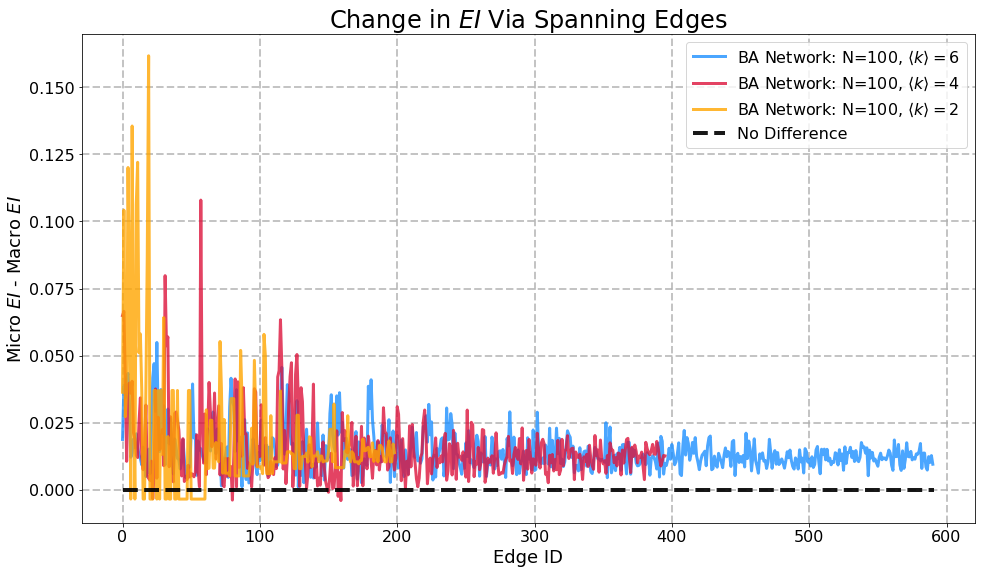

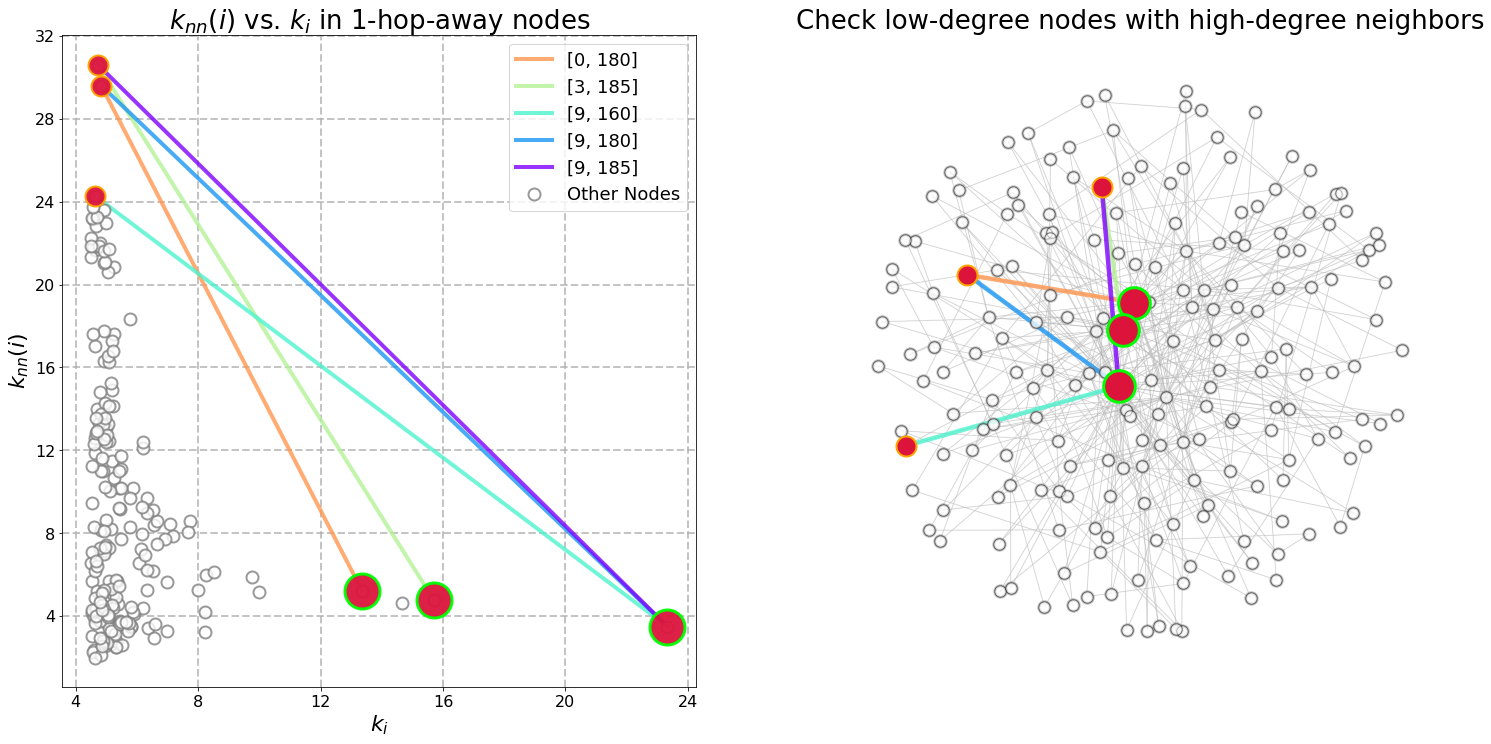

In [692]:
plt.figure(figsize=(16,9))
plt.plot(ei_diff_edges3, lw=3.0, alpha=0.8, c='dodgerblue', label=r'BA Network: N=100, $\langle k \rangle=6$')
plt.plot(ei_diff_edges2, lw=3.0, alpha=0.8, c='crimson', label=r'BA Network: N=100, $\langle k \rangle=4$')
plt.plot(ei_diff_edges1, lw=3.0, alpha=0.8, c='orange', label=r'BA Network: N=100, $\langle k \rangle=2$')
plt.plot([0, len(ei_diff_edges3)],[0, 0], c='k', alpha=0.9, linestyle='--', lw=4.0, label="No Difference")

plt.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
plt.title("Change in $EI$ Via Spanning Edges", size=24)
plt.xlabel("Edge ID", size=18)
plt.ylabel("Micro $EI$ - Macro $EI$", size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
plt.savefig("figs/CausalEmergence_BA_DiffDegree.pdf", dpi=425, bbox_inches='tight')
plt.savefig("figs/CausalEmergence_BA_DiffDegree.png", dpi=425, bbox_inches='tight')
# plt.show()

nodebunch2 = list(set(i[0] for i in success_edges2).union(set(i[1] for i in success_edges2)))
nodebunch2_0 = list(set(i[0] for i in success_edges2))
nodebunch2_1 = list(set(i[1] for i in success_edges2))

knn_i = np.array(list(nx.assortativity.neighbor_degree.average_neighbor_degree(G2).values()))
deg_i = np.array(list(dict(G2.degree()).values()))
max_knn = int(max(np.array(list(nx.assortativity.neighbor_degree.average_neighbor_degree(G2).values()))))
max_deg = max(dict(G2.degree()).values())
deg_i = deg_i + np.random.uniform(-0.75, 0.75, size=len(deg_i))
knn_i = knn_i + np.random.uniform(-0.75, 0.75, size=len(knn_i))

edge_colors = [plt.cm.rainbow_r((np.array(range(len(success_edges2)))+1)/len(success_edges2))][0]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,12))
for i, eij in enumerate(success_edges2):
    ax0.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], 
             linestyle='-', color=edge_colors[i], linewidth=4.0, alpha=0.8, label=list(eij))
ax0.plot(deg_i, knn_i, marker='o', linestyle='', markersize=12, color='w', markeredgecolor='grey', 
         markeredgewidth=2.0, alpha=0.8, label='Other Nodes')
ax0.plot(deg_i[nodebunch2_1], knn_i[nodebunch2_1], marker='o', linestyle='', markersize=20, color='crimson', 
         markeredgecolor='orange', markeredgewidth=2.0, alpha=0.95)
ax0.plot(deg_i[nodebunch2_0], knn_i[nodebunch2_0], marker='o', linestyle='', markersize=35, color='crimson', 
         markeredgecolor='lime', markeredgewidth=3.0, alpha=0.95)
    
ax0.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
ax0.set_xlabel(r"$k_i$", size=22)
ax0.set_ylabel(r"$k_{nn}(i)$", size=22)
ax0.set_xticklabels(range(0, max_deg, 4), size=16)
ax0.set_yticklabels(range(0, max_knn, 4), size=16)
ax0.legend(fontsize=18)
ax0.set_title(r"$k_{nn}(i)$ vs. $k_i$ in 1-hop-away nodes", size=26)

pos = nx.spring_layout(G2, iterations=200, k=1.9)
nx.draw_networkx_nodes(G2, pos, node_color='w', linewidths=3, node_size=130, alpha=0.5, ax=ax1).set_edgecolor('grey')
nx.draw_networkx_nodes(G2, pos, node_color='w', linewidths=1, node_size=130, alpha=0.5, ax=ax1).set_edgecolor('k')
nx.draw_networkx_nodes(G2, pos, nodelist=nodebunch2_0, node_color='crimson', 
                       linewidths=3, node_size=1000, ax=ax1).set_edgecolor('lime')
nx.draw_networkx_nodes(G2, pos, nodelist=nodebunch2_1, node_color='crimson', 
                       linewidths=2, node_size=400, ax=ax1).set_edgecolor('orange')

nx.draw_networkx_edges(G2, pos, edge_color="gainsboro", width=1.05, alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G2, pos, edge_color="black", width=0.05, alpha=0.8, ax=ax1)
nx.draw_networkx_edges(G2, pos, edgelist=success_edges2, edge_color=edge_colors, width=4.5, alpha=0.8, ax=ax1)
ax1.set_title("Check low-degree nodes with high-degree neighbors", size=26)

plt.axis('off')
plt.savefig("figs/CausalEmergence_WhichNodesGoodMacronodes.pdf", dpi=425, bbox_inches='tight')
plt.savefig("figs/CausalEmergence_WhichNodesGoodMacronodes.png", dpi=425, bbox_inches='tight')
# plt.show()

## 4.1.0 Searching *Paths*: Which Nodes Make the Best Macronodes?
_________________________

In [ ]:
N = 200
K_avg = 2
d = 2
G = nx.barabasi_albert_graph(N, K_avg)
ei_G = get_ei(G)
ei_diff_edges = []
success_edges = []
paths_length_2 = get_paths(G, d)

for eij in paths_length_2:
    Gij = macronode(G, nodebunch=list(eij))
    ei_diff_edges.append(get_ei(G) - get_ei(Gij))

print("Random sample of Macronode-able edges for a BA Network with",
      N, "nodes and k_avg of",K_avg*2)
print("Edge ID \t (k_i, k_j) \t (EI_i, EI_j) \t\t EI_diff")
for i in range(len(ei_diff_edges)):
    if ei_diff_edges[i] < 0.0:
        success_edges.append(paths_length_2[i])
        if 0.1 > np.random.rand():
            print(paths_length_2[i], " \t", (G.degree(paths_length_2[i][0]), 
                                             G.degree(paths_length_2[i][1])), 
                "\t", (np.round(get_ei_i(G, paths_length_2[i][0]), 4), 
                       np.round(get_ei_i(G, paths_length_2[i][1]), 4)), 
                " \t", np.round(ei_diff_edges[i], 4))

In [694]:
success_edge_amount = []
for i in range(len(ei_diff_edges)):
    if ei_diff_edges[i] < 0.0:
        success_edge_amount.append(ei_diff_edges[i])

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(ei_diff_edges, lw=0.5, alpha=0.8, c='dodgerblue', 
         label=r'BA Network: N=200, $\langle k \rangle=4$')
plt.plot([0, len(ei_diff_edges)],[0, 0], c='k', alpha=0.9, 
         linestyle='--', lw=4.0, label="No Difference")

plt.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
plt.title("Change in $EI$ Via Spanning Paths of Length 2", size=24)
plt.xlabel("Macronode Pairing", size=18)
plt.ylabel("Micro $EI$ - Macro $EI$", size=18)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)
# plt.savefig("figs/CausalEmergence_BA_PathLen2.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CausalEmergence_BA_PathLen2.png", dpi=425, bbox_inches='tight')
plt.show()

In [697]:
ei_G_1hop = get_ei(G)
ei_diff_edges_1hop = []
success_edges_1hop = []
success_edge_amount_1hop = []
edges_1hop = list(G.edges())
        
for eij in edges_1hop:
    Gij = macronode(G, nodebunch=list(eij))
    ei_diff_edges_1hop.append(get_ei(G) - get_ei(Gij))
for i in range(len(ei_diff_edges_1hop)):
    if ei_diff_edges_1hop[i] < 0.0:
        success_edge_amount_1hop.append(ei_diff_edges_1hop[i])
        success_edges_1hop.append(edges_1hop[i])

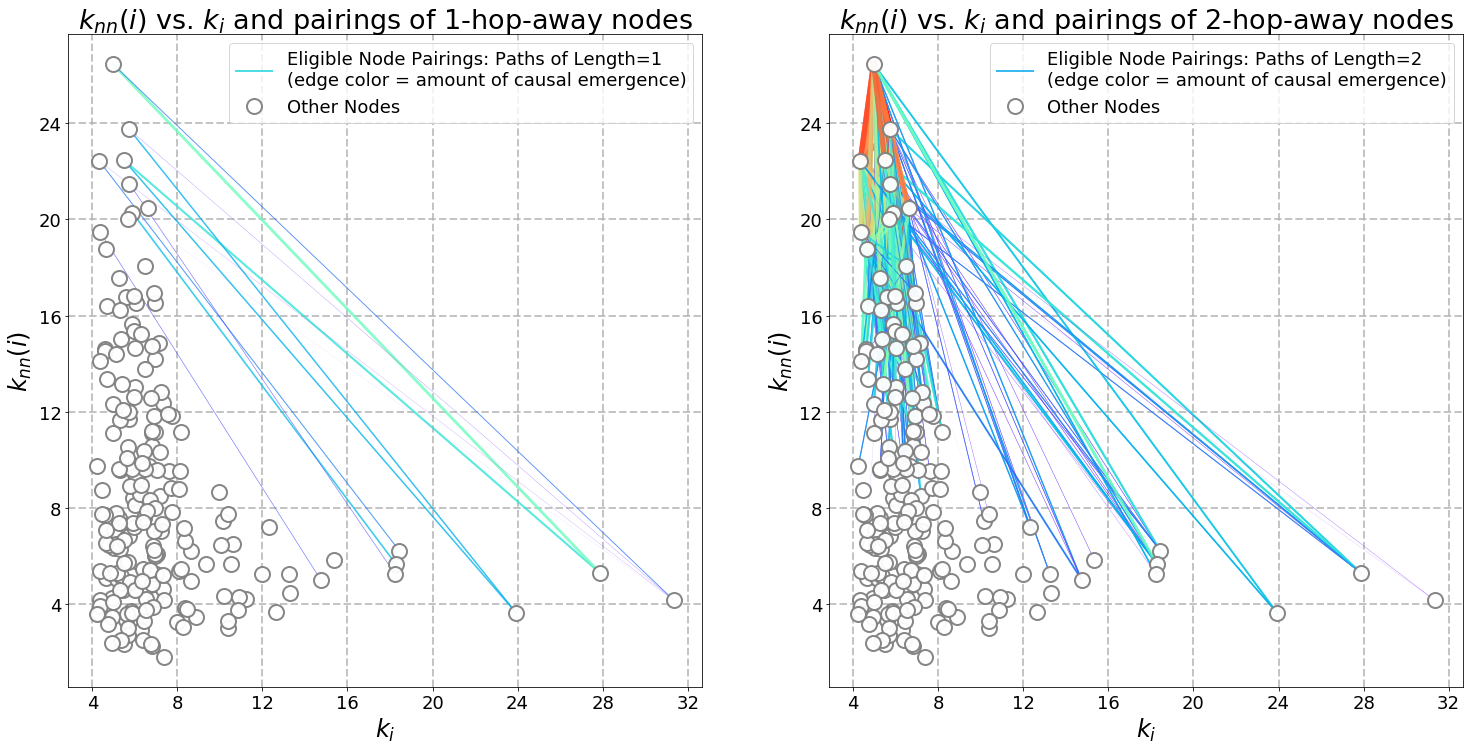

In [701]:
knn_i = np.array(list(nx.assortativity.neighbor_degree.average_neighbor_degree(G).values()))
deg_i = np.array(list(dict(G.degree()).values()))
max_knn = int(max(np.array(list(nx.assortativity.neighbor_degree.average_neighbor_degree(G).values()))))+3
max_deg = max(dict(G.degree()).values())+3
deg_i = deg_i + np.random.uniform(-1.75, 1.75, size=len(deg_i))
knn_i = knn_i + np.random.uniform(-1.75, 1.75, size=len(knn_i))

biggest = max([-min(success_edge_amount), -min(success_edge_amount_1hop)])
ei_rank = (-np.array(success_edge_amount))/biggest
ei_rank_1hop = (-np.array(success_edge_amount_1hop))/biggest
edge_colors = [plt.cm.rainbow(ei_rank)][0]
edge_colors_1hop = [plt.cm.rainbow(ei_rank_1hop)][0]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(25,12))

ax0.plot([deg_i[0], deg_i[0]], [knn_i[0], knn_i[0]], linestyle='-', color=edge_colors[0], 
         linewidth=2.0, alpha=0.8, 
         label='Eligible Node Pairings: Paths of Length=1\n(edge color = amount of causal emergence)')
for i, eij in enumerate(success_edges_1hop):
    ax0.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], 
             linestyle='-', color=edge_colors_1hop[i], linewidth=6.0*ei_rank_1hop[i], alpha=0.8)
ax0.plot(deg_i, knn_i, marker='o', linestyle='', markersize=15, color='w', markeredgecolor='grey', 
         markeredgewidth=2.0, alpha=0.95, label='Other Nodes')
    
ax0.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
ax0.set_xlabel(r"$k_i$", size=24)
ax0.set_ylabel(r"$k_{nn}(i)$", size=24)
ax0.set_xticklabels(range(0, max_deg, 4), size=18)
ax0.set_yticklabels(range(0, max_knn, 4), size=18)
ax0.legend(fontsize=18)
ax0.set_title(r"$k_{nn}(i)$ vs. $k_i$ and pairings of 1-hop-away nodes", size=27)

ax1.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], linestyle='-', 
         color=edge_colors[i], linewidth=2.0, alpha=0.8, 
         label='Eligible Node Pairings: Paths of Length=2\n(edge color = amount of causal emergence)')
for i, eij in enumerate(success_edges):
    ax1.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], 
             linestyle='-', color=edge_colors[i], linewidth=6.0*ei_rank[i], alpha=0.8)#
ax1.plot(deg_i, knn_i, marker='o', linestyle='', markersize=15, color='w', markeredgecolor='grey', 
         markeredgewidth=2.0, alpha=0.95, label='Other Nodes')
    
ax1.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
ax1.set_xlabel(r"$k_i$", size=24)
ax1.set_ylabel(r"$k_{nn}(i)$", size=24)
ax1.set_xticklabels(range(0, max_deg, 4), size=18)
ax1.set_yticklabels(range(0, max_knn, 4), size=18)
ax1.legend(fontsize=18)
ax1.set_title(r"$k_{nn}(i)$ vs. $k_i$ and pairings of 2-hop-away nodes", size=27)
plt.savefig("figs/CausalEmergence_BA_PathLen1and2.pdf", dpi=425, bbox_inches='tight')
plt.savefig("figs/CausalEmergence_BA_PathLen1and2.png", dpi=425, bbox_inches='tight')
# plt.show()

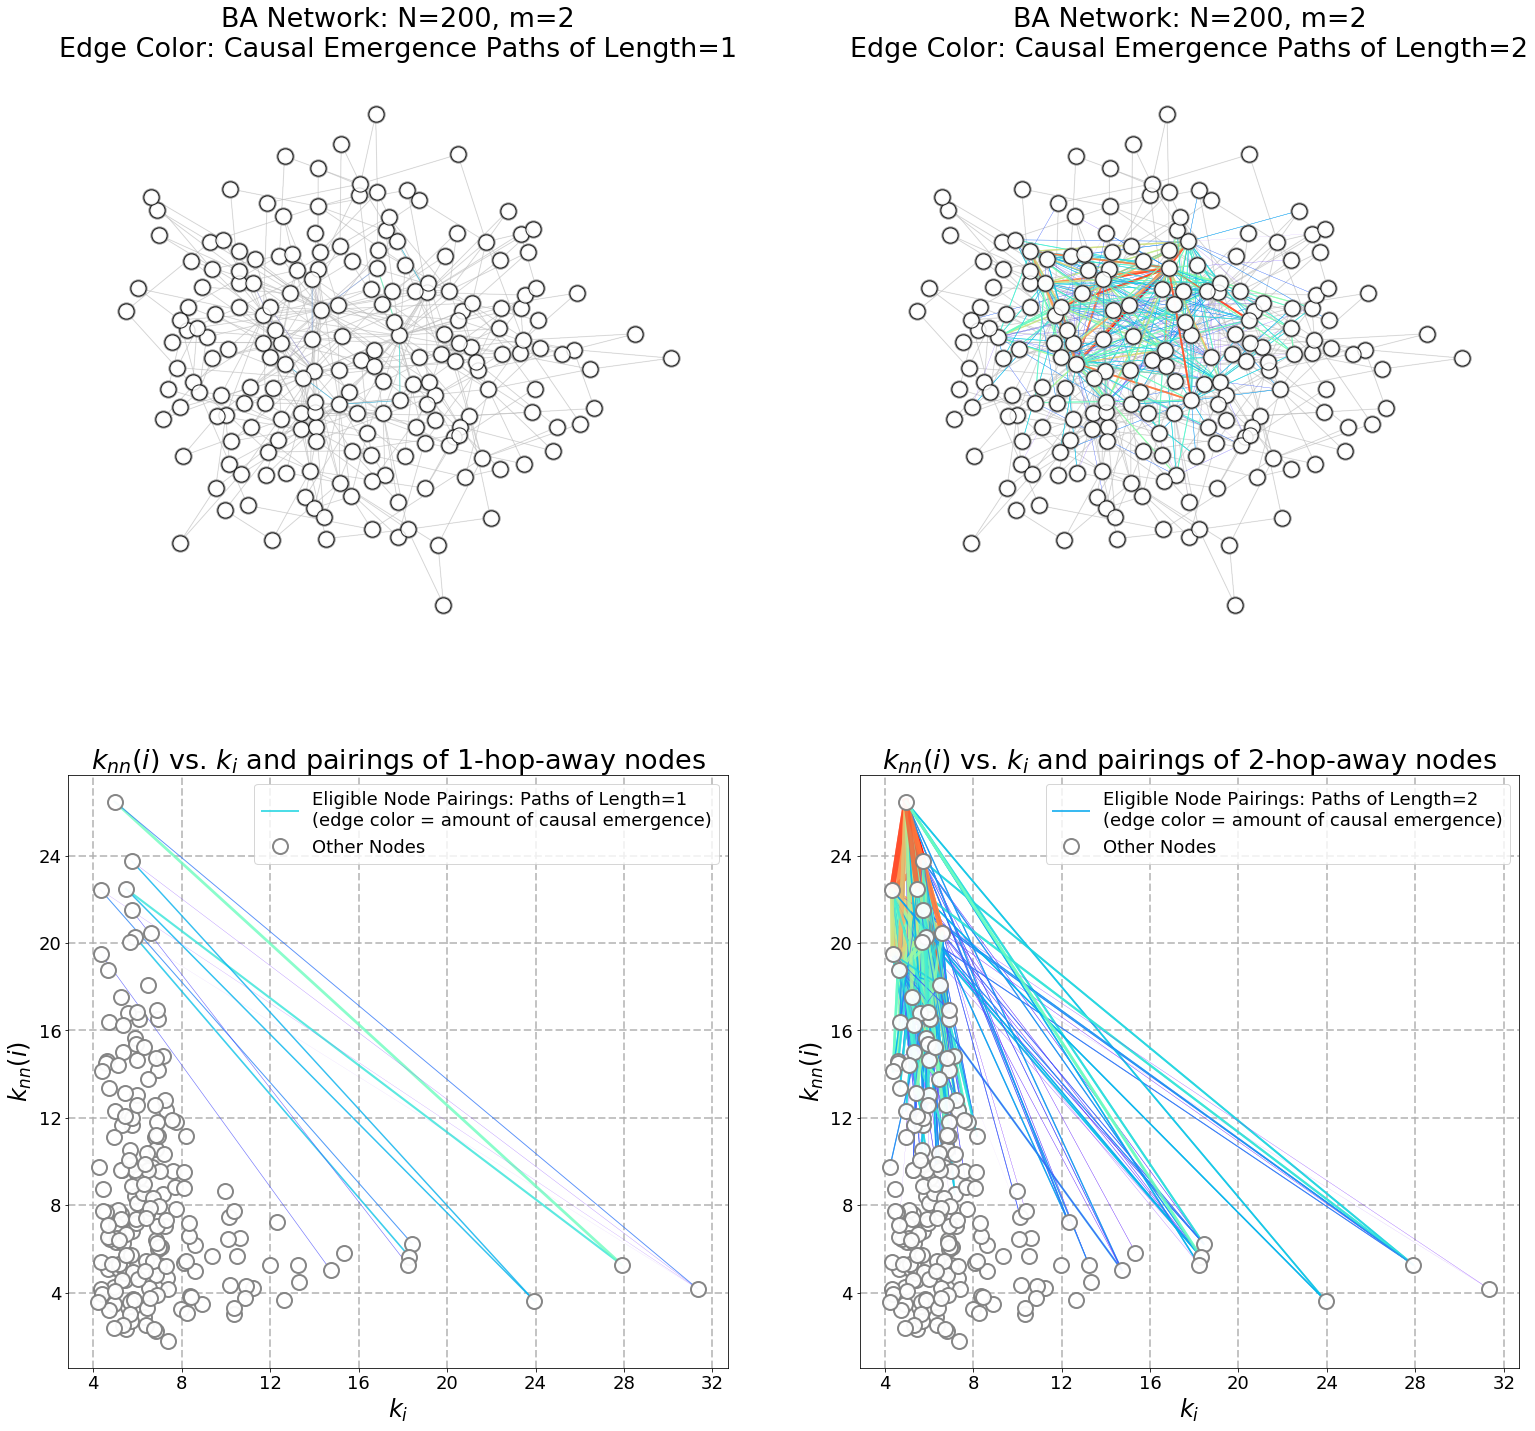

In [722]:
fig, ((ax2, ax3),(ax0, ax1)) = plt.subplots(2, 2, figsize=(26,24))

ax0.plot([deg_i[0], deg_i[0]], [knn_i[0], knn_i[0]], linestyle='-', color=edge_colors[0], 
         linewidth=2.0, alpha=0.8, 
         label='Eligible Node Pairings: Paths of Length=1\n(edge color = amount of causal emergence)')
for i, eij in enumerate(success_edges_1hop):
    ax0.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], 
             linestyle='-', color=edge_colors_1hop[i], linewidth=6.0*ei_rank_1hop[i], alpha=0.8)
ax0.plot(deg_i, knn_i, marker='o', linestyle='', markersize=15, color='w', markeredgecolor='grey', 
         markeredgewidth=2.0, alpha=0.95, label='Other Nodes')
    
ax0.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
ax0.set_xlabel(r"$k_i$", size=24)
ax0.set_ylabel(r"$k_{nn}(i)$", size=24)
ax0.set_xticklabels(range(0, max_deg, 4), size=18)
ax0.set_yticklabels(range(0, max_knn, 4), size=18)
ax0.legend(fontsize=18)
ax0.set_title(r"$k_{nn}(i)$ vs. $k_i$ and pairings of 1-hop-away nodes", size=27)

ax1.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], linestyle='-', 
         color=edge_colors[i], linewidth=2.0, alpha=0.8, 
         label='Eligible Node Pairings: Paths of Length=2\n(edge color = amount of causal emergence)')
for i, eij in enumerate(success_edges):
    ax1.plot([deg_i[list(eij)[0]], deg_i[list(eij)[1]]], [knn_i[list(eij)[0]], knn_i[list(eij)[1]]], 
             linestyle='-', color=edge_colors[i], linewidth=6.0*ei_rank[i], alpha=0.8)#
ax1.plot(deg_i, knn_i, marker='o', linestyle='', markersize=15, color='w', markeredgecolor='grey', 
         markeredgewidth=2.0, alpha=0.95, label='Other Nodes')
    
ax1.grid(True, linestyle='--', linewidth=2.0, alpha=0.75)
ax1.set_xlabel(r"$k_i$", size=24)
ax1.set_ylabel(r"$k_{nn}(i)$", size=24)
ax1.set_xticklabels(range(0, max_deg, 4), size=18)
ax1.set_yticklabels(range(0, max_knn, 4), size=18)
ax1.legend(fontsize=18)
ax1.set_title(r"$k_{nn}(i)$ vs. $k_i$ and pairings of 2-hop-away nodes", size=27)

pos = nx.spring_layout(G)#, iterations=200, k=1.9)
nx.draw_networkx_nodes(G, pos, node_color='w', linewidths=3, node_size=230, alpha=0.85, ax=ax2).set_edgecolor('grey')
nx.draw_networkx_nodes(G, pos, node_color='w', linewidths=1, node_size=230, alpha=0.85, ax=ax2).set_edgecolor('k')
nx.draw_networkx_edges(G, pos, edge_color="gainsboro", width=1.05, alpha=0.8, ax=ax2)
nx.draw_networkx_edges(G, pos, edge_color="black", width=0.05, alpha=0.8, ax=ax2)
nx.draw_networkx_edges(G, pos, edgelist=success_edges_1hop, edge_color=edge_colors_1hop, 
                       width=2.0*ei_rank_1hop, alpha=0.8, ax=ax2)
ax2.set_title("BA Network: N=200, m=2\nEdge Color: Causal Emergence Paths of Length=1", size=27)
ax2.axis('off')

nx.draw_networkx_nodes(G, pos, node_color='w', linewidths=3, node_size=230, alpha=0.85, ax=ax3).set_edgecolor('grey')
nx.draw_networkx_nodes(G, pos, node_color='w', linewidths=1, node_size=230, alpha=0.85, ax=ax3).set_edgecolor('k')
nx.draw_networkx_edges(G, pos, edge_color="gainsboro", width=1.05, alpha=0.8, ax=ax3)
nx.draw_networkx_edges(G, pos, edge_color="black", width=0.05, alpha=0.8, ax=ax3)
nx.draw_networkx_edges(G, pos, edgelist=success_edges, edge_color=edge_colors, 
                       width=2.0*ei_rank, alpha=0.8, ax=ax3)
ax3.set_title("BA Network: N=200, m=2\nEdge Color: Causal Emergence Paths of Length=2", size=27)
ax3.axis('off')

# plt.savefig("figs/CausalEmergence_CompareBA.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/CausalEmergence_CompareBA.png", dpi=425, bbox_inches='tight')
plt.show()

By grouping over paths of length=2, many more nodes become eligible to become macronodes than simply using edges (paths of length=1). This can be exploited in the future in order to find efficient ways of calculating causal emergence.
_______________

## End of Chapter 04. In Chapter 05 we will explore novel applications of Causal Emergence
_______________

### References:
- __[Anderson, P. W. (1972). More is different. Science,177(4047), 393–396. doi: 10.1126/science.177.4047.393](http://robotics.cs.tamu.edu/dshell/cs689/papers/anderson72more_is_different.pdf)__
- __[Bunge, M. (1963). A General Black Box Theory. Philosophy of Science, 30(4), 346–358. doi: 10.1086/287954](https://www.journals.uchicago.edu/doi/10.1086/287954)__
- __[Campbell, D. T. (1974). ‘Downward Causation’ in Hierarchically Organised Biological Systems. In *Studies in the philosophy of biology.* (pp. 179–186). doi: 10.1007/978-1-349-01892-5-11](https://link.springer.com/chapter/10.1007%2F978-1-349-01892-5_11)__
- __[Crutchfield, J. P. (1994). The Calculi of Emergence. Physica D, 75, 11–54. doi: 10.1016/0167-2789(94)90273-9](https://www.sciencedirect.com/science/article/pii/0167278994902739)__
- __[Fodor, J. A. (1974). Special Sciences (Or: The Disunity of Science as a Working Hypothesis). Synthese,28(2), 97–115. doi: 10.1007/BF00485230](https://www.jstor.org/stable/20114958)__
- __[Hoel, E. P. (2017). When the Map Is Better Than the Territory. Entropy, 19(5), 188. doi: 10.3390/e19050188](http://www.mdpi.com/1099-4300/19/5/188)__
- __[Hoel, E. P., Albantakis, L., & Tononi, G. (2013). Quantifying causal emergence shows that macro can beat micro. Proceedings of the National Academy of Sciences, 110(49), 19790–5. doi: 10.1073/pnas.1314922110](http://www.pnas.org/content/110/49/19790)__
- __[Kim, J. (2000). Mind in a physical world: An essay on the mind-body problem and mental causation. MITPress.](https://mitpress.mit.edu/books/mind-physical-world)__
- __[Shannon, C. E. (1948). A mathematical theory of communication. The Bell System Technical Journal, 27(July 1928), 379–423. doi: 10.1145/584091.584093](http://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)__
- __[Sperry, R. W. (1969). A modified concept of consciousness. Psychological Review, 76(6), 532–536. doi: 10.1037/h0028156](http://www.informationphilosopher.com/solutions/scientists/sperry/Sperry_Modified_Consciousness.pdf)__
- __[Wolpert, D. H., Grochow, J. A., Libby, E., & DeDeo, S. (2014). Optimal high-level descriptions of dynamical systems. arXiv, 1–33.](https://arxiv.org/abs/1409.7403)__